# 🏠 Bài tập mở rộng: Tuning các mô hình hồi quy dự đoán giá nhà


## 🎯 Mục tiêu
- Dự đoán giá nhà là một bài toán hồi quy kinh điển trong lĩnh vực học máy, yêu cầu mô hình học được quan hệ phi tuyến giữa các đặc trưng (như thu nhập, mật độ dân cư, diện tích nhà, v.v.) và giá nhà.
- Các mô hình học máy có nhiều siêu tham số (hyperparameters) ảnh hưởng lớn đến hiệu suất dự đoán. Việc hiểu, tinh chỉnh và đánh giá các mô hình sẽ giúp:

  *   Hiểu được tác động của từng tham số lên kết quả dự đoán.
  *   Phân tích và trực quan hóa quá trình tuning qua biểu đồ parallel_coordinates.
  *  Kỹ thuật tuning hyperparameters bằng GridSearchCV,..


- Xây dựng và tinh chỉnh 5 mô hình hồi quy, so sánh hiệu năng, phân tích ảnh hưởng của từng tham số và rút ra kết luận về hiệu quả của từng mô hình. Tuning tham số bằng `GridSearchCV` cho 5 mô hình:
  - `SVR`
  - `KNeighborsRegressor`
  - `RandomForestRegressor`
  - `DecisionTreeRegressor`
  - `Ridge`
- Đánh giá hiệu suất mô hình bằng MSE, MAE và R².


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

# Tiền xử lý dữ liệu

In [27]:
# Đọc dữ liệu và xử lý
df = pd.read_csv('./USA_Housing.csv')
df = df.drop('Address', axis=1)

# Scale 2 cột đặc trưng
scale = MinMaxScaler()
df['Avg. Area Income'] = scale.fit_transform(np.array(df['Avg. Area Income']).reshape(-1, 1))
df['Area Population'] = scale.fit_transform(np.array(df['Area Population']).reshape(-1, 1))

# Tách X, y
y = df['Price']
x = df.drop('Price', axis=1)

# Chia train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.01, random_state=42)

In [28]:
def evaluate_model(model, param_grid, X_train, y_train, X_test, y_test, model_name="Model"):
    grid = GridSearchCV(model, param_grid, cv=5, scoring='mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n📌 {model_name}")
    print("Best parameters:", grid.best_params_)
    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R² : {r2:.4f}")

    return grid.best_estimator_


In [29]:
def compare_default_and_tuned_models(x_train, x_test, y_train, y_test, best_estimator, model_name="Model"):
    """
    So sánh trực quan mô hình mặc định và mô hình đã tuning cho bất kỳ mô hình hồi quy nào.
    """

    # Lấy class gốc của mô hình để tạo phiên bản mặc định
    model_class = best_estimator.__class__
    default_model = model_class()
    default_model.fit(x_train, y_train)
    y_pred_default = default_model.predict(x_test)
    y_pred_tuned = best_estimator.predict(x_test)

    # Tính metric cho cả hai mô hình
    metrics = lambda y_true, y_pred: {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred)
    }
    default_metrics = metrics(y_test, y_pred_default)
    tuned_metrics = metrics(y_test, y_pred_tuned)

    # Trực quan hóa
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Mô hình mặc định
    axes[0].scatter(y_test, y_pred_default, c='red', alpha=0.6)
    axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '-', label="Đường lý tưởng")
    axes[0].set_title(f"{model_name} - Mặc định\nMSE: {default_metrics['MSE']:.3f} | MAE: {default_metrics['MAE']:.3f}")
    axes[0].set_xlabel("Giá trị thực tế")
    axes[0].set_ylabel("Giá trị dự đoán")
    axes[0].legend()

    # Mô hình đã tuning
    axes[1].scatter(y_test, y_pred_tuned, c='blue', alpha=0.6)
    axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '-', label="Đường lý tưởng")
    axes[1].set_title(f"{model_name} - Tối ưu\nMSE: {tuned_metrics['MSE']:.3f} | MAE: {tuned_metrics['MAE']:.3f}")
    axes[1].set_xlabel("Giá trị thực tế")
    axes[1].set_ylabel("Giá trị dự đoán")
    axes[1].legend()

    plt.suptitle(f"So sánh hiệu suất: {model_name}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [30]:
# Xây dựng từ điển param_grids chứa các tập hợp siêu tham số cần thử nghiệm cho mỗi mô hình.

param_grids = {
    "SVR": {
        'C': [1, 10, 1000, 10000, 1000000],
        'epsilon': [0.01, 0.1, 1],
        'kernel': ['linear', 'rbf', 'poly']

    },
    "KNeighborsRegressor": {
        'n_neighbors': [3, 5, 7, 9, 11, 13],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    "RandomForestRegressor": {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    "DecisionTreeRegressor": {
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 2]
    },
    "Ridge": {
        'alpha': [0.001, 0.01, 0.1, 1, 2],
        'solver': ['auto', 'svd', 'cholesky']
    }
}

In [31]:
# Tạo biểu đồ trực quan hóa kết quả tìm kiếm siêu tham số bằng biểu đồ parallel_coordinates
# Giúp hiểu ảnh hưởng của từng siêu tham số đến kết quả loss.

import plotly.express as px

def visualize_tuning_results(grid, model_name, loss_metric='mean_test_score', negate_score=True):
    results_df = pd.DataFrame(grid.cv_results_)

    # Lấy cột tham số và score
    param_cols = [col for col in results_df.columns if col.startswith('param_')]
    selected_cols = param_cols + [loss_metric]
    vis_df = results_df[selected_cols].copy()

    # Tạo cột Loss
    vis_df['Loss'] = -vis_df[loss_metric] if negate_score else vis_df[loss_metric]
    vis_df.drop(columns=[loss_metric], inplace=True)

    # Ánh xạ các giá trị chuỗi sang số để vẽ được
    str_mappings = {}  # lưu lại ánh xạ để hiển thị sau

    for col in param_cols:
        if vis_df[col].dtype == 'object':
            unique_vals = vis_df[col].unique()
            mapping = {val: idx for idx, val in enumerate(unique_vals)}
            str_mappings[col] = mapping
            vis_df[col] = vis_df[col].map(mapping)

    # Đổi tên cột cho ngắn gọn
    vis_df.rename(columns={col: col.replace('param_', '') for col in vis_df.columns}, inplace=True)

    # Vẽ biểu đồ
    fig = px.parallel_coordinates(
        vis_df,
        color='Loss',
        labels={col.replace('param_', ''): col.replace('param_', '') for col in param_cols} | {'Loss': 'Loss'},
        title=f"Tuning Visualization - {model_name}"
    )
    fig.show()

    if str_mappings:
        print(f"\n🔤 String-to-Int Mappings for {model_name}:")
        for col, mapping in str_mappings.items():
            print(f" - {col.replace('param_', '')}: {mapping}")



# Huấn luyện các mô hình

In [32]:
# Khởi tạo mô hình và dictionary lưu mô hình tốt nhất

models = {
    "SVR": SVR(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
    "Ridge": Ridge()
}

best_models = {}
model_results = {}

## Mô hình ***SVR***

🔍 Đang tuning mô hình: SVR...
📌 SVR
Best parameters: {'C': 1000000, 'epsilon': 0.01, 'kernel': 'linear'}
Test MSE: 9396052266.1842
Test MAE: 75002.0129
Test R² : 0.8973



🔤 String-to-Int Mappings for SVR:
 - C: {1: 0, 10: 1, 1000: 2, 10000: 3, 1000000: 4}
 - epsilon: {0.01: 0, 0.1: 1, 1: 2}
 - kernel: {'linear': 0, 'rbf': 1, 'poly': 2}


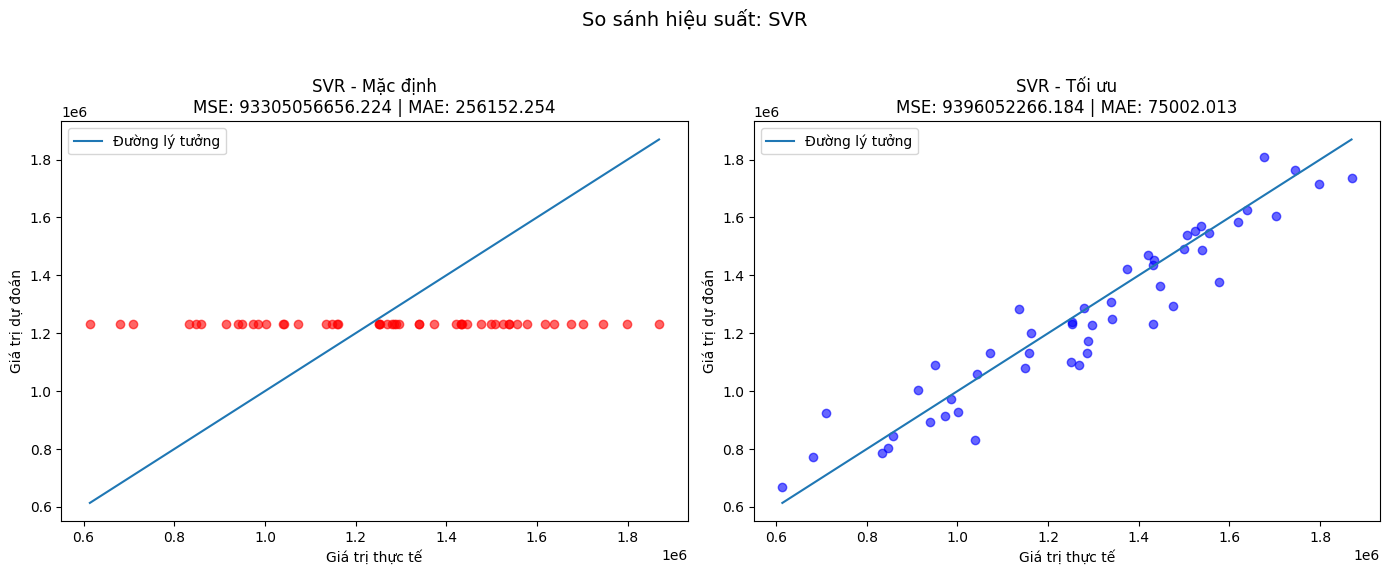

✅ Hoàn thành: SVR
--------------------------------------------------


In [33]:
# Chạy tuning và trực quan hóa cho mô hình SVR

name = "SVR"
model = models[name]
print(f"🔍 Đang tuning mô hình: {name}...")

grid = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(x_train, y_train)

y_pred = grid.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📌 {name}")
print("Best parameters:", grid.best_params_)
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R² : {r2:.4f}")

best_models[name] = grid.best_estimator_
model_results[name] = {
    "MSE": mse,
    "MAE": mae,
    "R2": r2
}

# Trực quan hóa kết quả tìm kiếm siêu tham số
visualize_tuning_results(grid, model_name=name)

# Trực quan hóa mức độ chính xác của mô hình khi dùng bộ tham số tối ưu và bộ tham số mặc định bằng cách so sánh giữa giá trị thực tế (y_test) và giá trị dự đoán (y_pred) thông qua biểu đồ phân tán.
compare_default_and_tuned_models(x_train, x_test, y_train, y_test, grid.best_estimator_, model_name=name)

print(f"✅ Hoàn thành: {name}\n{'-'*50}")


In [34]:
import numpy as np
import matplotlib.pyplot as plt

def plot_svr_predictions(x_train, y_train, x_test, y_test, model, title="SVR Prediction"):
    # Dự đoán trên toàn bộ dữ liệu để vẽ đường hồi quy mượt
    x_all = np.linspace(x_train.min(), x_train.max(), 500).reshape(-1, 1)
    y_all_pred = model.predict(x_all)

    # Dự đoán trên tập test
    y_test_pred = model.predict(x_test)

    plt.figure(figsize=(10, 6))
    plt.scatter(x_train, y_train, color="gray", alpha=0.5, label="Train data")
    plt.scatter(x_test, y_test, color="blue", label="Test data")
    plt.plot(x_all, y_all_pred, color="red", label="SVR prediction (tuned)")
    plt.scatter(x_test, y_test_pred, color="green", label="Predicted (test)", marker="x")

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### 🧠 Câu hỏi phân tích
1. Dựa trên biểu đồ, bạn thấy tổ hợp giá trị nào cho ra Loss thấp nhất?

2. Có tham số nào dường như có ảnh hưởng lớn hơn đến xu hướng của hàm Loss so với các tham số khác không?

3. Nêu một đường trong biểu đồ cho thấy một cấu hình tệ (Loss cao), nếu có. Bạn có thể xác định được tham số nào gây ra điều đó?

4.  Khi lựa chọn bộ siêu tham số để huấn luyện mô hình, bộ siêu tham số sẽ xoay quanh các giá trị tham số là bao nhiêu? Vì sao

Câu 1:
- Tổ hợp cho Loss thấp nhất (~ 10.28B):
    - C = 1000000
    - epsilon = 0.01
    - kernel = 'linear'

Câu 2:
- C là tham số có ảnh hưởng lớn nhất: Khi C tăng, mô hình càng cố gắng fit dữ liệu → giảm Loss rõ rệt.
- epsilon cũng có ảnh hưởng nhất định: Giá trị epsilon nhỏ như 0.01 giúp SVR không bỏ qua các sai số nhỏ.
- kernel ảnh hưởng nhẹ hơn trong trường hợp này, nhưng linear đã cho kết quả tốt hơn so với rbf.    

Câu 3:
- Một cấu hình có Loss cao (đường vàng nhất trong biểu đồ) có thể là:
    - C = 0.1
    - epsilon = 5
    - kernel = 'rbf'

- Nguyên nhân:
    - C quá nhỏ → mô hình không đủ phức tạp để học tốt (underfitting).
    - epsilon quá lớn → bỏ qua quá nhiều sai số nhỏ.
    - rbf không phù hợp khi dữ liệu phù hợp hơn với mối quan hệ tuyến tính (như hiện tại).

- Theo kết quả tuning:
    - C nên lấy giá trị lớn, khoảng 10^5 đến 10^6
    - epsilon nhỏ, khoảng 0.01
    - kernel = 'linear'

## Mô hình ***KNeighborsRegressor***

🔍 Đang tuning mô hình: KNeighborsRegressor...
📌 KNeighborsRegressor
Best parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Test MSE: 34020326240.1504
Test MAE: 145917.3538
Test R² : 0.6282



🔤 String-to-Int Mappings for KNeighborsRegressor:
 - n_neighbors: {3: 0, 5: 1, 7: 2, 9: 3, 11: 4, 13: 5}
 - p: {1: 0, 2: 1}
 - weights: {'uniform': 0, 'distance': 1}


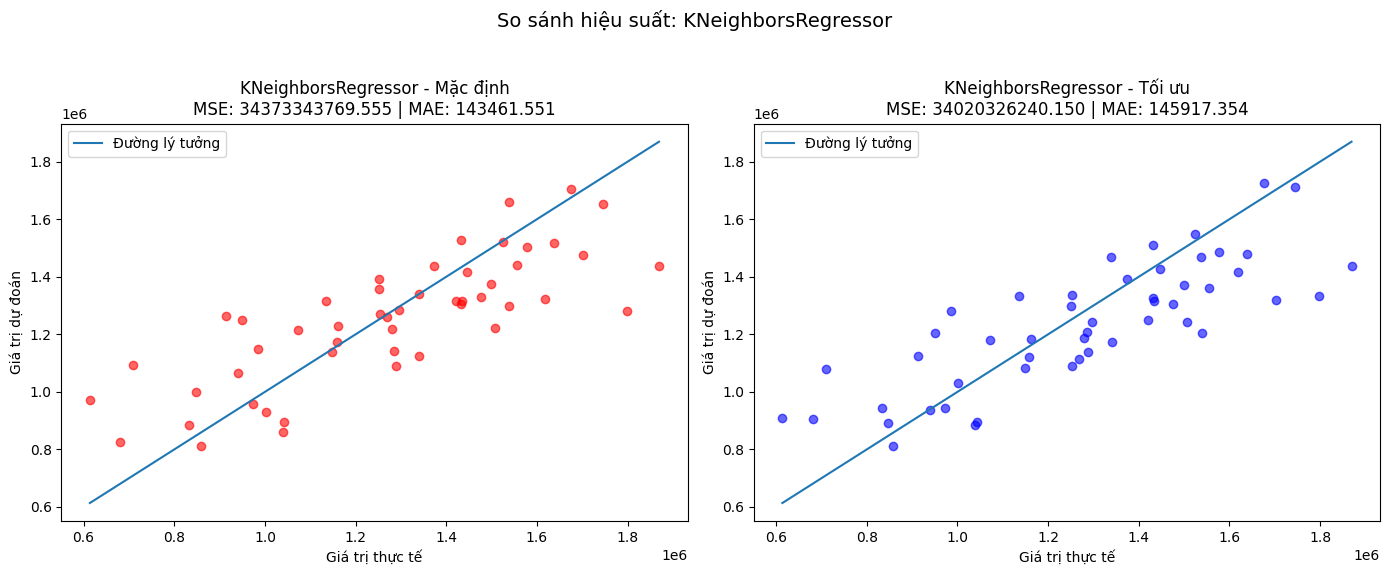

✅ Hoàn thành: KNeighborsRegressor
--------------------------------------------------


In [35]:
# Chạy tuning và trực quan hóa cho mô hình KNeighborsRegressor

name = "KNeighborsRegressor"
model = models[name]
print(f"🔍 Đang tuning mô hình: {name}...")

grid = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(x_train, y_train)

y_pred = grid.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📌 {name}")
print("Best parameters:", grid.best_params_)
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R² : {r2:.4f}")

best_models[name] = grid.best_estimator_
model_results[name] = {
    "MSE": mse,
    "MAE": mae,
    "R2": r2
}

# Trực quan hóa kết quả tìm kiếm siêu tham số
visualize_tuning_results(grid, model_name=name)

# Trực quan hóa mức độ chính xác của mô hình khi dùng bộ tham số tối ưu và bộ tham số mặc định bằng cách so sánh giữa giá trị thực tế (y_test) và giá trị dự đoán (y_pred) thông qua biểu đồ phân tán.
compare_default_and_tuned_models(x_train, x_test, y_train, y_test, grid.best_estimator_, model_name=name)

print(f"✅ Hoàn thành: {name}\n{'-'*50}")


### 🧠 Câu hỏi phân tích
1. Dựa trên biểu đồ, bạn thấy tổ hợp giá trị nào cho ra Loss thấp nhất?

2. Có tham số nào dường như có ảnh hưởng lớn hơn đến xu hướng của hàm Loss so với các tham số khác không?

3. Nêu một đường trong biểu đồ cho thấy một cấu hình tệ (Loss cao), nếu có. Bạn có thể xác định được tham số nào gây ra điều đó?

4.  Khi lựa chọn bộ siêu tham số để huấn luyện mô hình, bộ tham số sẽ xoay quanh các giá trị siêu tham số là bao nhiêu? Vì sao?

Câu 1:
- Tổ hợp cho Loss thấp nhất là:
    - n_neighbors: 5
    - p: 1
    - weights: distance
- Loss ~43.13B → đây là tổ hợp tốt nhất.  

Câu 2:
- Tổ hợp cho Loss tệ nhất là:
    - n_neighbors = 13
    - p = 2
    - weights = uniform
- Loss = ~51.48B → tổ hợp tệ nhất.

Câu 3:
- Với cùng các tham số khác, p=1 (Manhattan distance) thường cho Loss thấp hơn so với p=2 (Euclidean distance).
- Điều này cho thấy Manhattan distance hoạt động hiệu quả hơn trong bài toán này.
- Kết luận: Giá trị p=1 nên được ưu tiên nếu mục tiêu là giảm sai số dự đoán.

Câu 4:
- n_neighbors = [3,5,7] -> Các giá trị nhỏ giúp mô hình phản ứng nhạy hơn với các mẫu gần, từ đó giảm Loss.
- p = 1 -> Manhattan distance hoạt động tốt hơn trong bài toán này so với Euclidean.
- weight = "distance" -> Các điểm gần ảnh hưởng mạnh hơn, giúp cải thiện độ chính xác.

## Mô hình ***RandomForestRegressor***

In [36]:
name = "RandomForestRegressor"
model = models[name]

🔍 Đang tuning mô hình: RandomForestRegressor...
📌 RandomForestRegressor
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Test MSE: 12812238665.5309
Test MAE: 79055.6054
Test R² : 0.8600



🔤 String-to-Int Mappings for RandomForestRegressor:
 - max_depth: {None: 0, 10: 1, 20: 2}
 - min_samples_split: {2: 0, 5: 1}
 - n_estimators: {10: 0, 50: 1, 100: 2, 200: 3}


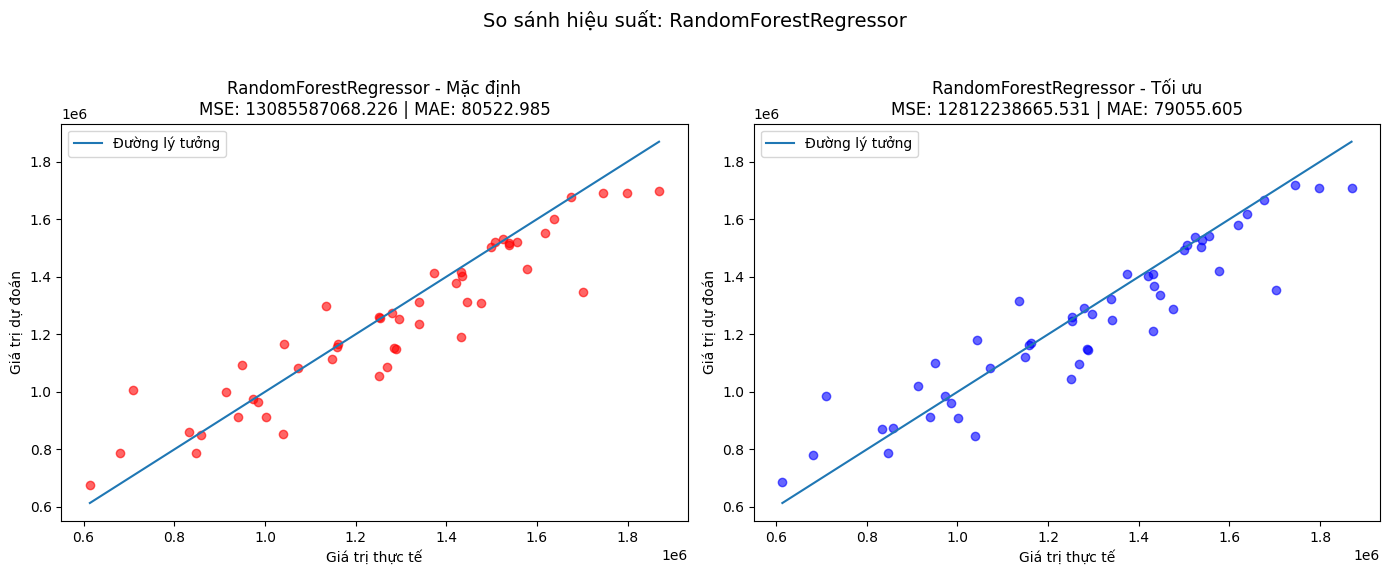

✅ Hoàn thành: RandomForestRegressor
--------------------------------------------------


In [37]:
# Chạy tuning và trực quan hóa cho mô hình RandomForestRegressor

name = "RandomForestRegressor"
model = models[name]
print(f"🔍 Đang tuning mô hình: {name}...")

grid = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(x_train, y_train)

y_pred = grid.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📌 {name}")
print("Best parameters:", grid.best_params_)
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R² : {r2:.4f}")

best_models[name] = grid.best_estimator_
model_results[name] = {
    "MSE": mse,
    "MAE": mae,
    "R2": r2
}

# Trực quan hóa kết quả tìm kiếm siêu tham số
visualize_tuning_results(grid, model_name=name)

# Trực quan hóa mức độ chính xác của mô hình khi dùng bộ tham số tối ưu và bộ tham số mặc định bằng cách so sánh giữa giá trị thực tế (y_test) và giá trị dự đoán (y_pred) thông qua biểu đồ phân tán.
compare_default_and_tuned_models(x_train, x_test, y_train, y_test, grid.best_estimator_, model_name=name)

print(f"✅ Hoàn thành: {name}\n{'-'*50}")

### 🧠 Câu hỏi phân tích
1. Dựa trên biểu đồ, bạn thấy tổ hợp giá trị nào cho ra Loss thấp nhất?

2. Có tham số nào dường như có ảnh hưởng lớn hơn đến xu hướng của hàm Loss so với các tham số khác không?

3. Nêu một đường trong biểu đồ cho thấy một cấu hình tệ (Loss cao), nếu có. Bạn có thể xác định được tham số nào gây ra điều đó?

4.  Khi lựa chọn bộ siêu tham số để huấn luyện mô hình, bộ tham số sẽ xoay quanh các giá trị siêu tham số là bao nhiêu? Vì sao

Câu 1:
- Tổ hợp giá trị cho Loss thấp nhất (~14.2983B) là: 
    - max_depth = None 
    - min_samples_split = 5 
    - n_estimators = 200

Câu 2:  
➡️ Quan sát độ phân tán màu sắc theo từng trục:

- max_depth và n_estimators có vẻ ảnh hưởng lớn hơn.

- Khi max_depth = 2 → Loss thường rất cao (vàng đậm).

- n_estimators nhỏ (10) → Loss cao hơn hẳn. Tăng n_estimators thường kéo giảm Loss.

🔍 Trong khi đó:

- min_samples_split không tạo ra biến động Loss rõ rệt khi giữ các tham số khác cố định.

🟡 Kết luận: max_depth và n_estimators có ảnh hưởng lớn hơn đến chất lượng mô hình.

Câu 3:  
🔍 Có một đường màu vàng nổi bật (Loss cao nhất ~16.1009B), tương ứng với:
- max_depth = 2 (giới hạn độ sâu rất nhỏ)
- min_samples_split = 5
- n_estimators = 10

➡️ Nguyên nhân chính:
- max_depth = 2 khiến cây cực kỳ nông, không học được nhiều đặc trưng → underfitting.
- n_estimators = 10 quá ít cây → giảm tính ngẫu nhiên & độ ổn định của rừng.


Câu 4:
- max_depth: None hoặc 10+	-> Giúp cây học sâu hơn → giảm Loss rõ rệt
- min_samples_split:	2 ->	Cho phép chia nhỏ hơn → mô hình linh hoạt
- n_estimators:	100–200	-> Càng nhiều cây → càng ổn định và giảm lỗi

## Mô hình ***DecisionTreeRegressor***

🔍 Đang tuning mô hình: DecisionTreeRegressor...
📌 DecisionTreeRegressor
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6}
Test MSE: 26104444188.5141
Test MAE: 130362.3806
Test R² : 0.7147



🔤 String-to-Int Mappings for DecisionTreeRegressor:
 - max_depth: {None: 0, 5: 1, 10: 2}
 - min_samples_leaf: {1: 0, 2: 1}
 - min_samples_split: {2: 0, 4: 1, 6: 2}


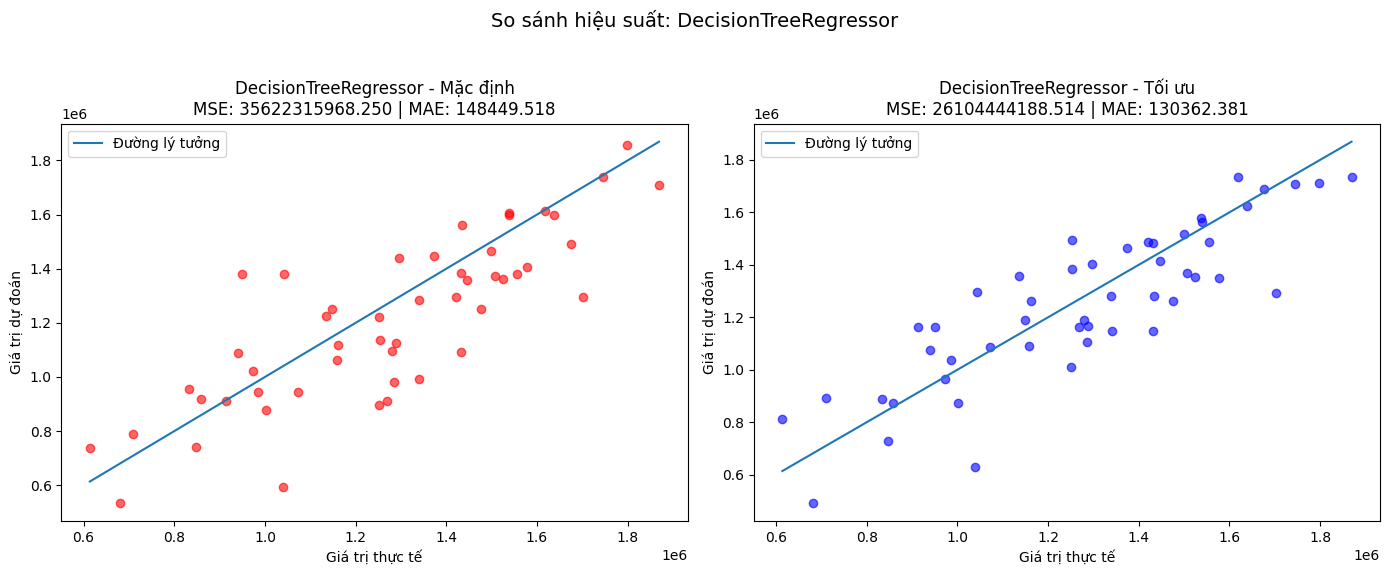

✅ Hoàn thành: DecisionTreeRegressor
--------------------------------------------------


In [38]:
# Chạy tuning và trực quan hóa cho mô hình DecisionTreeRegressor

name = "DecisionTreeRegressor"
model = models[name]
print(f"🔍 Đang tuning mô hình: {name}...")

grid = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(x_train, y_train)

y_pred = grid.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📌 {name}")
print("Best parameters:", grid.best_params_)
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R² : {r2:.4f}")

best_models[name] = grid.best_estimator_
model_results[name] = {
    "MSE": mse,
    "MAE": mae,
    "R2": r2
}

# Trực quan hóa kết quả tìm kiếm siêu tham số
visualize_tuning_results(grid, model_name=name)

# Trực quan hóa mức độ chính xác của mô hình khi dùng bộ tham số tối ưu và bộ tham số mặc định bằng cách so sánh giữa giá trị thực tế (y_test) và giá trị dự đoán (y_pred) thông qua biểu đồ phân tán.
compare_default_and_tuned_models(x_train, x_test, y_train, y_test, grid.best_estimator_, model_name=name)

print(f"✅ Hoàn thành: {name}\n{'-'*50}")

### 🧠 Câu hỏi phân tích
1. Dựa trên biểu đồ, bạn thấy tổ hợp giá trị nào cho ra Loss thấp nhất?

2. Có tham số nào dường như có ảnh hưởng lớn hơn đến xu hướng của hàm Loss so với các tham số khác không?

3. Nêu một đường trong biểu đồ cho thấy một cấu hình tệ (Loss cao), nếu có. Bạn có thể xác định được tham số nào gây ra điều đó?

4.  Khi lựa chọn bộ siêu tham số để huấn luyện mô hình, bộ tham số sẽ xoay quanh các giá trị siêu tham số là bao nhiêu? Vì sao

Câu 1:
- max_depth = 10 
- min_samples_leaf = 2
- min_samples_split = 6
- 📈Loss ~ 27.115B

Câu 2:  
🔍 Phân tích các trục:
- max_depth có vẻ ảnh hưởng rõ rệt nhất:
    - Khi max_depth = 1 → đa phần là màu vàng (Loss rất cao ~41.818B)
    - Khi max_depth = 2 → vẫn còn màu vàng, ít hơn
    - Khi max_depth = 3 → hầu hết là màu tím và tím nhạt (Loss thấp)

Điều này cho thấy độ sâu cây quyết định rất lớn đến khả năng dự đoán.

📉 Ngược lại:

- min_samples_leaf và min_samples_split ảnh hưởng nhỏ hơn, màu sắc không thay đổi nhiều dọc trục.

🟡 Kết luận: max_depth ảnh hưởng nhiều nhất đến Loss.

Câu 3:  
🔍 Đường màu vàng nhất (Loss ~ 41.818B) tương ứng với:

- max_depth = 1
- min_samples_leaf = 2
- min_samples_split = 6

🟡 Nguyên nhân:

- max_depth = 1 làm cây quá nông → underfitting nghiêm trọng, không học được các phân tách phức tạp.

🧨 Dù có thay đổi min_samples_leaf hay min_samples_split, nhưng nếu độ sâu chỉ là 1 thì vẫn không hiệu quả.

Câu 4:
- max_depth:	3 hoặc cao hơn	-> Giảm rõ Loss, tránh underfitting
- min_samples_leaf:	1–2	-> Các giá trị nhỏ hoạt động tốt hơn
- min_samples_split:	2–4	-> Dễ chia nhỏ giúp cây linh hoạt hơn

## Mô hình ***Ridge***

🔍 Đang tuning mô hình: Ridge...
📌 Ridge
Best parameters: {'alpha': 0.001, 'solver': 'auto'}
Test MSE: 9405945341.4754
Test MAE: 75146.1247
Test R² : 0.8972



🔤 String-to-Int Mappings for Ridge:
 - alpha: {0.001: 0, 0.01: 1, 0.1: 2, 1: 3, 2: 4}
 - solver: {'auto': 0, 'svd': 1, 'cholesky': 2}


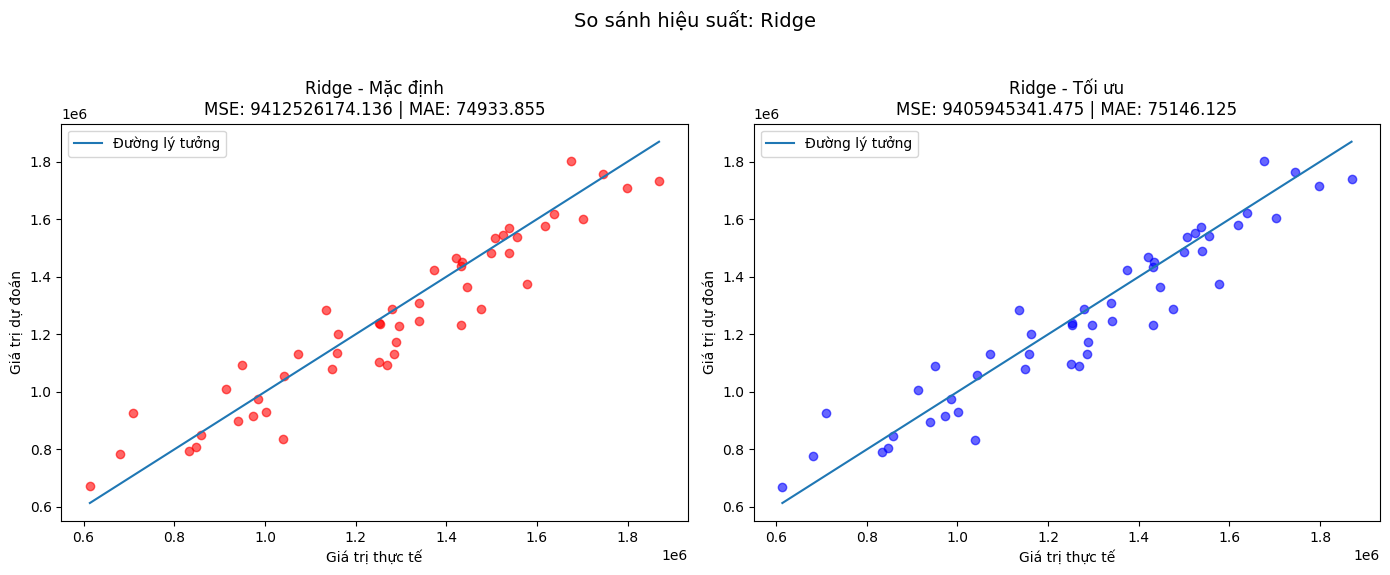

✅ Hoàn thành: Ridge
--------------------------------------------------


In [39]:
# Chạy tuning và trực quan hóa cho mô hình Ridge

name = "Ridge"
model = models[name]
print(f"🔍 Đang tuning mô hình: {name}...")

grid = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(x_train, y_train)

y_pred = grid.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📌 {name}")
print("Best parameters:", grid.best_params_)
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R² : {r2:.4f}")
model_results[name] = {
    "MSE": mse,
    "MAE": mae,
    "R2": r2
}

best_models[name] = grid.best_estimator_
model_results[name] = {
    "MSE": mse,
    "MAE": mae,
    "R2": r2
}

# Trực quan hóa kết quả tìm kiếm siêu tham số
visualize_tuning_results(grid, model_name=name)

# Trực quan hóa mức độ chính xác của mô hình khi dùng bộ tham số tối ưu và bộ tham số mặc định bằng cách so sánh giữa giá trị thực tế (y_test) và giá trị dự đoán (y_pred) thông qua biểu đồ phân tán.
compare_default_and_tuned_models(x_train, x_test, y_train, y_test, grid.best_estimator_, model_name=name)


print(f"✅ Hoàn thành: {name}\n{'-'*50}")

### 🧠 Câu hỏi phân tích
1. Dựa trên biểu đồ, bạn thấy tổ hợp giá trị nào cho ra Loss thấp nhất?

2. Có tham số nào dường như có ảnh hưởng lớn hơn đến xu hướng của hàm Loss so với các tham số khác không?

3. Nêu một đường trong biểu đồ cho thấy một cấu hình tệ (Loss cao), nếu có. Bạn có thể xác định được tham số nào gây ra điều đó?

4.  Khi lựa chọn bộ siêu tham số để huấn luyện mô hình, bộ siêu tham số sẽ xoay quanh các giá trị tham số là bao nhiêu? Vì sao

Câu 1:
- alpha: 0.001
- solver: 'auto'  
- 📉 Loss ~ 10.260265B

Câu 2:   
🔍 So sánh sự thay đổi màu sắc khi di chuyển dọc theo từng trục, alpha ảnh hưởng mạnh nhất:

- Khi alpha = 2 → đa phần là màu vàng (Loss cao)

- Khi alpha giảm xuống 0.001 → màu xanh đậm (Loss thấp nhất)

- Màu chuyển từ vàng → tím → xanh đậm rõ ràng theo trục alpha

- solver thay đổi nhưng không tạo ra sự khác biệt lớn về màu sắc

🟡 Kết luận: alpha có ảnh hưởng lớn hơn đến Loss so với solver

Câu 3:  
🔍 Quan sát một trong các đường màu vàng nhất (Loss ~ 10.339338B), ta thấy:
- alpha = 2
- solver = 'cholesky' (ứng với 2)
🧨 Nguyên nhân chính: alpha quá lớn → mô hình bị regularize quá mạnh → underfitting dữ liệu

Câu 4:
- alpha:	0.001 → 0.1	 -> Giảm rõ Loss, tránh over-regularization
- solver:	auto, svd	-> Cho kết quả ổn định, không chênh lệch nhiều

## So sánh kết quả của các mô hình

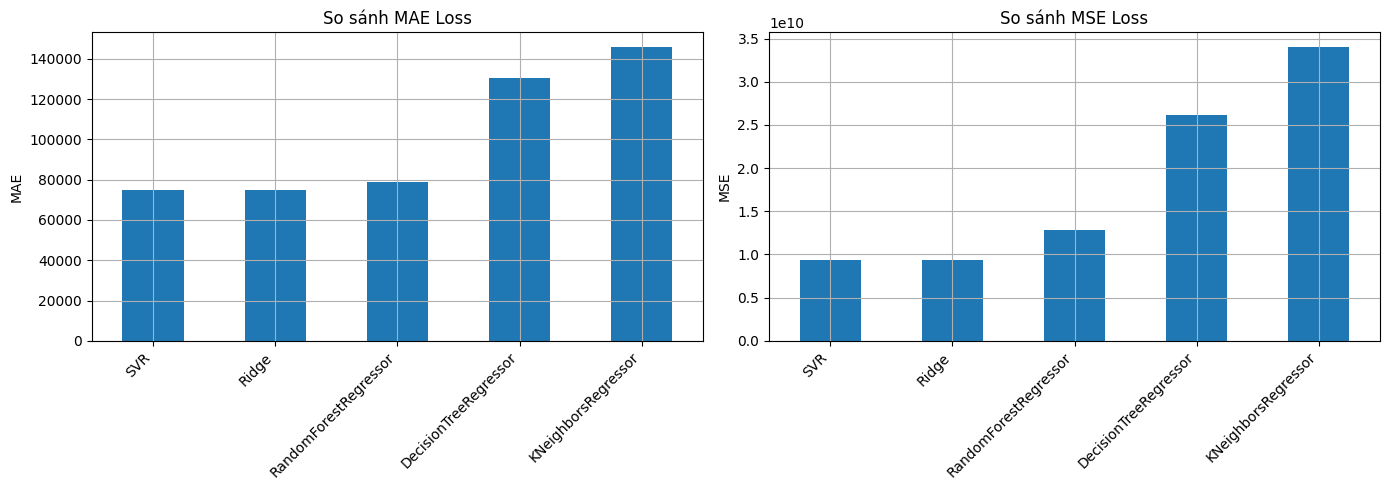

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Chuyển sang DataFrame
df_metrics = pd.DataFrame(model_results).T
df_metrics_sorted = df_metrics.sort_values(by='MAE')
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ MSE
df_metrics_sorted['MSE'].plot(kind='bar', ax=axes[1], title='So sánh MSE Loss')
axes[1].set_ylabel('MSE')
axes[1].set_xticklabels(df_metrics_sorted.index, rotation=45, ha='right')
axes[1].grid(True)

# Biểu đồ MAE
df_metrics_sorted['MAE'].plot(kind='bar', ax=axes[0], title='So sánh MAE Loss')
axes[0].set_ylabel('MAE')
axes[0].set_xticklabels(df_metrics_sorted.index, rotation=45, ha='right')
axes[0].grid(True)

plt.tight_layout()
plt.show()


In [41]:
summary_df = pd.DataFrame(model_results)
print("\n📊 Tổng hợp đánh giá các mô hình:")
display(summary_df)



📊 Tổng hợp đánh giá các mô hình:


,SVR,KNeighborsRegressor,RandomForestRegressor,DecisionTreeRegressor,Ridge
MSE,9.396052e+09,3.402033e+10,1.281224e+10,2.610444e+10,9.405945e+09
MAE,7.500201e+04,1.459174e+05,7.905561e+04,1.303624e+05,7.514612e+04
R2,8.973050e-01,6.281717e-01,8.599674e-01,7.146890e-01,8.971968e-01


Kết luận: nên chọn mô hình:
- Ridge Regression với alpha = 0.001, solver = 'auto'

Lý do:

- Hiệu suất tốt gần tương đương hoặc bằng với mô hình tốt nhất (SVR)
- Dễ huấn luyện, dễ triển khai, ít rủi ro overfitting hơn các cây
- Rất nhanh và đáng tin cậy cho dữ liệu tuyến tính hoặc gần tuyến tính